In [1]:
pip install split_folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import splitfolders
splitfolders.ratio("../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone", output="dataset", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 12446 files [02:15, 91.82 files/s] 


In [3]:
# Let's pip install effcientnet libarary
!pip install -q efficientnet

In [4]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications.vgg16 import VGG16 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical
# Import all the libraries 
import os
import shutil
from PIL import Image, ImageOps  
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
import plotly.graph_objects as go
import plotly.express as px
import datetime
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio
pio.templates.default = 'plotly_white'
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Concatenate, Flatten, MaxPooling2D, Conv2D
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
import efficientnet.tfkeras as efn
from tqdm import tqdm_notebook

In [5]:
channels=3
batch_size=25
test_batch_size=32 
test_steps=1
train_path = './dataset/train'
test_path = './dataset/test'
val_path = './dataset/val'
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)



train_generator=trgen.flow_from_directory( directory=train_path , target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_generator=tvgen.flow_from_directory( directory=test_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_generator=tvgen.flow_from_directory( directory=val_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_generator.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_generator.labels)/batch_size))

test batch size:  32   test steps:  1
Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


In [6]:
#Creating an EffNet model
model_B7 = efn.EfficientNetB7(weights='imagenet', input_shape=(224,224,3), include_top=False)

258449408/258434480 [==============================] - 1s 0us/step


In [7]:
pretrained_model = model_B7
pretrained_model.trainable=True
set_trainable=False

for layer in pretrained_model.layers:
    if layer.name == 'block7c_project_conv':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False


model=Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(4,activation=('softmax')))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
flatten (Flatten)            (None, 125440)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              128451584 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [9]:
batch_size= 1218
epochs=15
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
history = model.fit(train_generator,epochs = 5
          , validation_data = valid_generator, verbose = 1)

Epoch 1/5
399/399 [==============================] - 2113s 5s/step - loss: 1.3795 - accuracy: 0.3746 - val_loss: 1.2890 - val_accuracy: 0.4082
Epoch 2/5
399/399 [==============================] - 2081s 5s/step - loss: 1.3124 - accuracy: 0.3944 - val_loss: 1.3051 - val_accuracy: 0.2979
Epoch 3/5
399/399 [==============================] - 2106s 5s/step - loss: 1.2997 - accuracy: 0.3955 - val_loss: 1.2928 - val_accuracy: 0.4082
Epoch 4/5
399/399 [==============================] - 2081s 5s/step - loss: 1.2897 - accuracy: 0.4038 - val_loss: 1.3042 - val_accuracy: 0.2979
Epoch 5/5
399/399 [==============================] - 2082s 5s/step - loss: 1.2906 - accuracy: 0.4049 - val_loss: 1.2844 - val_accuracy: 0.4082


In [11]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 40:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [12]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

          Filename                Predicted Class                True Class           Probability   

     Cyst/Cyst- (1).jpg                Normal                       Cyst                0.4114

   Cyst/Cyst- (1008).jpg               Normal                       Cyst                0.4114

   Cyst/Cyst- (1044).jpg               Normal                       Cyst                0.4114

   Cyst/Cyst- (1054).jpg               Normal                       Cyst                0.4114

   Cyst/Cyst- (1056).jpg               Normal                       Cyst                0.4114

   Cyst/Cyst- (1061).jpg               Normal                       Cyst                0.4114

   Cyst/Cyst- (1064).jpg               Normal                       Cyst                0.4114

   Cyst/Cyst- (1075).jpg               Normal                       Cyst                0.4114

   Cyst/Cyst- (1089).jpg               Normal                       Cyst                0.4114

   Cyst/Cyst- (1090).jpg          

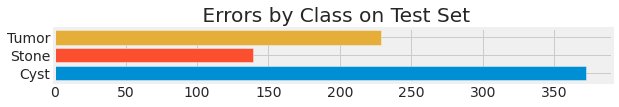

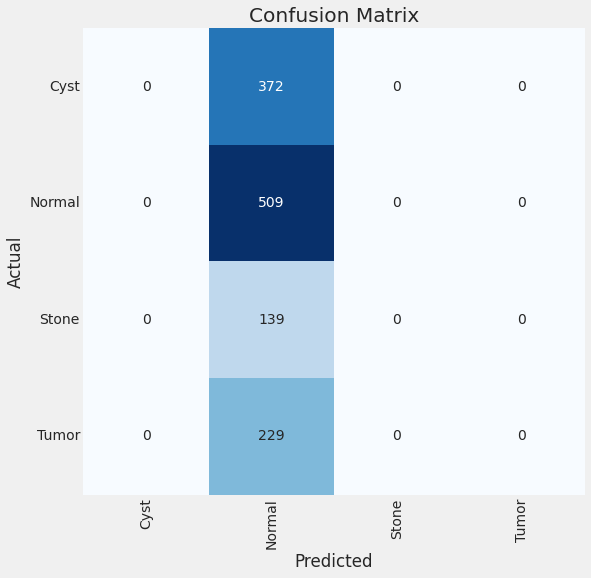

Classification Report:
----------------------
               precision    recall  f1-score   support

        Cyst       0.00      0.00      0.00       372
      Normal       0.41      1.00      0.58       509
       Stone       0.00      0.00      0.00       139
       Tumor       0.00      0.00      0.00       229

    accuracy                           0.41      1249
   macro avg       0.10      0.25      0.14      1249
weighted avg       0.17      0.41      0.24      1249



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [13]:
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
p = model.predict(test_generator)
print_info( test_generator, p, 10, r'./', 'kidney' ) 

In [14]:
model.evaluate(test_generator)

40/40 [==============================] - 187s 5s/step - loss: 1.2853 - accuracy: 0.4075


[1.2853443622589111, 0.40752601623535156]

In [15]:
model.save("EfficientnetB7.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [16]:
import shutil 
shutil.rmtree('./dataset')

In [17]:
history.params
history.history.keys()
type(history.history['loss'])
len(history.history['loss'])

5

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

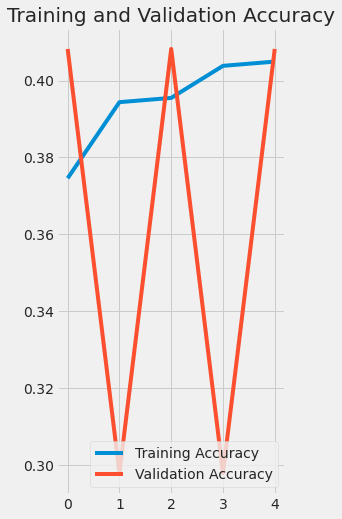

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(5), acc, label='Training Accuracy')
plt.plot(range(5), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

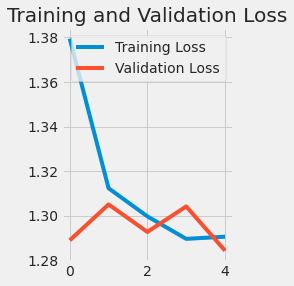

In [21]:
plt.subplot(1, 2, 2)
plt.plot(range(5), loss, label='Training Loss')
plt.plot(range(5), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()